# SAT をサーベイ伝搬法で解く

## 1. 文献情報

- タイトル: Survey Propagation: An Algorithm for Satisfiability
- 著者: A. Braunstein, M. Mézard, R. Zecchina
- 書誌情報: https://doi.org/10.1002/rsa.20057

## 2. 概要

$K$-SAT は，いくつかの変数からなる論理式を充足するような真偽値の割当を求める組合せ最適化問題です．ランダムな $K$-SAT インスタンスの充足可能性は，節の個数と変数の個数の比 $\alpha=M/N$ を変えると，ある点で急激に変化することが知られています．具体的には，ある臨界値 $\alpha_{\mathrm{clust}}, \alpha_c$ が存在して，以下のような挙動を示します．
- $\alpha < \alpha_{\mathrm{clust}}$ (easy-SAT 領域): ほとんどのインスタンスが充足可能であり，シミュレーテッドアニーリング (SA) などのアルゴリズムで容易に解が得られる．
- $\alpha_{\mathrm{clust}} < \alpha < \alpha_{c}$ (hard-SAT 領域): ほとんどのインスタンスが充足可能であるが，局所解が非常に多く，SAなどで解を見つけることが困難である．
- $\alpha > \alpha_c$ (UNSAT 領域): ほとんどのインスタンスが充足不可能である．

文献 [2] では， $K=3$ に対して $\alpha_{\mathrm{clust}} \approx 3.9$, $\alpha_c \approx 4.3$ が報告されています．

本記事では，ランダムな 3-SAT のインスタンスを解くアルゴリズムをいくつか実装して性能を比較します．そして，文献 [1] で提案された，サーベイ伝搬法に基づいたアルゴリズムが，hard-SAT 領域でも効率的に解を見つけられることを確認します．

## 3. 環境設定

### ライブラリのインポート

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(42)

## 4. 問題

$K$-SATのランダムインスタンスを生成する関数 `create_random_instance` を実装します．この関数では，$K$-SATインスタンスを CNF形式 (リテラルの論理和の論理積の形) で返します．例えば，論理式

$$
(x_0 \lor x_1 \lor x_2) \land (x_1 \lor \lnot x_2 \lor \lnot x_3) \land (\lnot x_0 \lor x_2 \lor x_3)
$$

という論理式は， 2次元配列として以下のように表されます．

```
[[0, 1, 2], [1, ~2, ~3], [~0, 2, 3]]
```

各節について， $K$ 個の変数を重複なしで一様ランダムに選択し，選ばれた各変数に対して肯定リテラルか否定リテラルかを確率 $1/2$ で決定します．

**実装の規則**
- 変数，節のindexは0始まりとする．
- true は $1$, false は $0$ に対応させる．
- 論理変数は$i,j,\dots$で表す．節は$a,b,\dots,$で表す．
- 肯定リテラルは `i`, 否定リテラルは `~i` で表す．符号を見れば肯定か否定かわかる．

In [ ]:
"""
N 変数 M 節の K-SAT インスタンスをランダムに作成する
"""


def create_random_instance(K, N, M):
    vars = range(N)
    clauses = []
    for _ in range(M):
        clause = []
        # K個の変数を選ぶ
        for i in random.sample(vars, K):
            # 肯定・否定を選ぶ
            if random.randint(0, 1) == 1:
                i = ~i
            clause.append(i)
        clauses.append(clause)
    return clauses

また，多くのアルゴリズムはSATインスタンスを因子グラフで表現して扱うため，インスタンスを因子グラフによる表現に変換する関数 `build_factor_graph` を用意します．因子グラフとは，変数ノードと因子ノードからなる二部グラフであり，因子 $a$ (この場合は節 $a$) が変数 $i$ の関数であるときに因子ノード $a$ と変数ノード $i$ の間に辺がはられているグラフです．

In [ ]:
"""
与えられたインスタンスから，因子グラフを構築する
- factor_to_var: 因子ノードから変数ノードへの隣接リスト
- var_to_factor: 変数ノードから因子ノードへの隣接リスト
- J: J[a][i] は，節 a で変数 i が肯定なら -1, 否定なら 1
"""


def build_factor_graph(N, clauses):
    M = len(clauses)

    factor_to_var = [[] for _ in range(M)]
    var_to_factor = [[] for _ in range(N + 1)]
    J = [{} for _ in range(M)]
    for a, clause in enumerate(clauses):
        for l in clause:
            if l >= 0:
                i = l
                J[a][i] = -1
            else:
                i = ~l
                J[a][i] = 1
            factor_to_var[a].append(i)
            var_to_factor[i].append(a)
    return factor_to_var, var_to_factor, J

## 5. ソルバの実装

ここでは，4つのアルゴリズムを実装します．
1. Hill climbing (HC, 山登り法)
2. Simulated annealing (SA, 焼きなまし法)
3. Warning inspired decimation (WID)
4. Survey inspired decimation (SID)

### 5.1 Hill Climbing

HCは最もシンプルな局所探索アルゴリズムです．変数をランダムに変更して，目的関数が改善したらその変更を採用するということを繰り返します．

具体的には，以下のようなアルゴリズムです．ここで，エネルギー $E$ を，充足されていない節の個数とします．

0. すべての変数の値をランダムに初期化する
1. 変数をランダムに1つ選択する
2. 選択した変数の真偽値をflipすることによるエネルギー変化 $\Delta E$ を計算する
3. $\Delta E < 0$ ならflipを採択，そうでなければ棄却する
4. $E=0$ となるか，既定のイテレーション上限に達したら終了する．そうでなければ，1に戻る

In [ ]:
"""
Hill Climbing を用いたソルバ
返り値は (最終的なエネルギー，最終的な変数の割り当て，エネルギーの推移)
"""


def hill_climbing(N, clauses, n_iter=10**4):
    M = len(clauses)
    factor_to_var, var_to_factor, J = build_factor_graph(N, clauses)

    # 変数の値をランダムに初期化
    value = [random.randint(0, 1) for i in range(N)]

    # エネルギーを計算
    energy = 0
    for a in range(M):
        val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
        if val == 0:
            energy += 1

    # エネルギーの履歴
    history = [energy]

    # すでに充足されていたら終了
    if energy == 0:
        return energy, value, history

    for _ in range(n_iter):
        # 変数をランダムに選択する
        i = random.randint(0, N - 1)

        # エネルギー変化
        delta = 0

        # flip前の充足されていない節を数える
        for a in var_to_factor[i]:
            val = 0
            val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
            if val == 0:
                delta -= 1

        # iをflipする
        value[i] = 1 - value[i]

        # flip後の充足されていない節を数える
        for a in var_to_factor[i]:
            val = 0
            val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
            if val == 0:
                delta += 1

        if delta < 0:
            # flipを採択
            energy += delta
        else:
            # flipを棄却
            value[i] = 1 - value[i]

        history.append(energy)

        # すべての節が充足されたら終了する
        if energy == 0:
            break

    return energy, value, history

3-SAT のランダムインスタンスに対して動作確認をします．

In [ ]:
K = 3
alpha = 1.2
N = 100
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

SAT
energy =  0


Text(0, 0.5, 'energy')

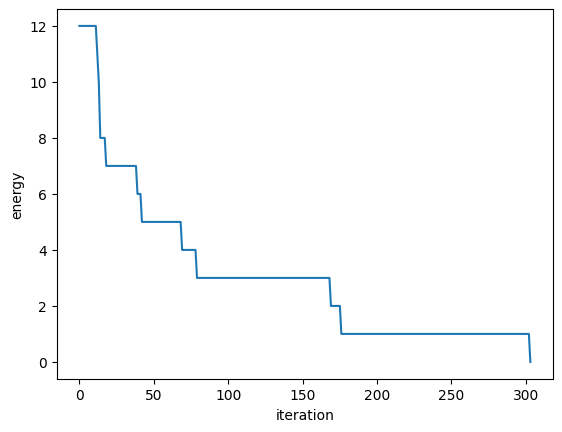

In [ ]:
energy, value, history = hill_climbing(N, clauses)
print("SAT" if energy == 0 else "UNSAT")
print("energy = ", energy)
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("energy")

エネルギーが単調に減少して解に到達していることがわかります．

### 5.2. Simulated Annealing

HCは，エネルギーの極小値が一つしかない場合には最適解に効率よく到達することができます．しかし，最適でない極小値に一度到達してしまうと，そこから抜け出すことができません．そして，$K$-SAT のインスタンスにはしばしば多くの局所解が存在するため，HCは効率的ではありません．

SAは，HCにランダム性を加えることで，局所解から脱出することを可能としたアルゴリズムです．このアルゴリズムは非常に汎用的である上に多くの問題に対して高い性能を示すため，広く用いられています．

SAは以下のようなアルゴリズムです．「温度 $T$」というパラメータを通して，ランダム性の強さを制御します．

0. すべての変数の値をランダムに初期化する
1. 温度 $T$ を更新する (本実装では，線形に変化させる)
2. 変数をランダムに1つ選択する
3. 選択した変数の真偽値をflipすることによるエネルギー変化 $\Delta E$ を計算する
4. 確率 $\min(1, \exp(-\Delta E/(NT)))$ で flipを採択，そうでなければ棄却する
5. $E=0$ となるか，既定のイテレーション上限に達したら終了する．そうでなければ，1に戻る

$T\to 0$ の極限で HC と一致します．

In [ ]:
"""
Simulated Annealing を用いたソルバ
返り値は (最良のエネルギー，最良の変数の割り当て，エネルギーの推移)
"""


def simulated_annealing(N, clauses, temp_begin, temp_end, n_iter=10**4):
    M = len(clauses)
    factor_to_var, var_to_factor, J = build_factor_graph(N, clauses)

    # 変数の値をランダムに初期化
    value = [random.randint(0, 1) for i in range(N)]

    # エネルギーを計算
    energy = 0
    for a in range(M):
        val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
        if val == 0:
            energy += 1

    # エネルギーの履歴
    history = [energy]

    # すでに充足されていたら終了
    if energy == 0:
        return energy, value, history

    # 最良の状態を保存
    best_energy = energy
    best_value = value[:]

    for k in range(n_iter):
        # 温度を更新
        temp = temp_end + (temp_begin - temp_end) * (1 - k / n_iter)

        # 変数をランダムに選択する
        i = random.randint(0, N - 1)

        # エネルギー変化
        delta = 0

        # flip前の充足されていない節を数える
        for a in var_to_factor[i]:
            val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
            if val == 0:
                delta -= 1

        # iをflipする
        value[i] = 1 - value[i]

        # flip後の充足されていない節を数える
        for a in var_to_factor[i]:
            val = sum(value[l] if l >= 0 else 1 - value[~l] for l in clauses[a])
            if val == 0:
                delta += 1

        if delta <= 0 or np.exp(-delta / (N * temp)) > random.random():
            # flipを採択
            energy += delta
        else:
            # flipを棄却
            value[i] = 1 - value[i]

        history.append(energy)

        # 最良の状態を更新
        if energy < best_energy:
            best_energy = energy
            best_value = value[:]

        # すべての節が充足されたら終了する
        if energy == 0:
            break

    return best_energy, best_value, history

3-SATのランダムインスタンスに対して動作確認をします．

In [ ]:
K = 3
alpha = 2.5
N = 100
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

SAT
energy =  0


Text(0, 0.5, 'energy')

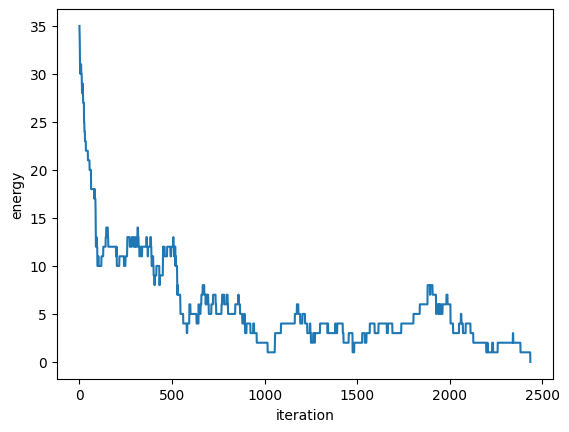

In [ ]:
energy, value, history = simulated_annealing(N, clauses, 5e-3, 1e-5)
print("SAT" if energy == 0 else "UNSAT")
print("energy = ", energy)
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("energy")

エネルギーが途中で増加することが見て取れます．エネルギーが増加するような遷移を確率的に許すことで，局所解を脱出しています．

HCを同じインスタンスに対して実行します．

UNSAT
energy =  5


Text(0, 0.5, 'energy')

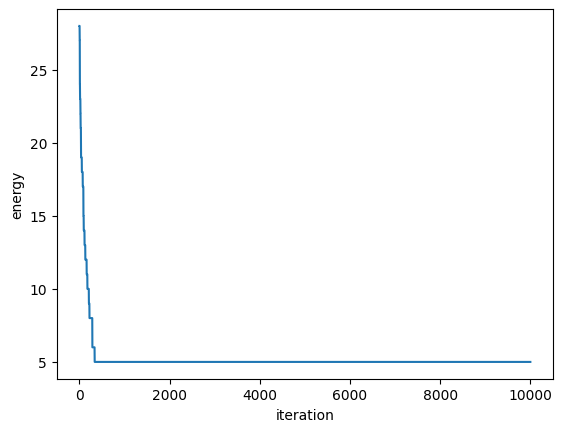

In [ ]:
energy, value, history = hill_climbing(N, clauses)
print("SAT" if energy == 0 else "UNSAT")
print("energy = ", energy)
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("energy")

局所解に捉われてしまい，最適解を発見することができませんでした．

つぎに，$K=3,N=100$ で，さまざまな $\alpha$ の値に対して $100$ 個のランダムインスタンスを作成し， HC, SA で最適解が得られる割合をそれぞれ計算することで，HC と SA の性能を比較してみます．

100%|██████████| 20/20 [03:39<00:00, 10.98s/it]


Text(0, 0.5, 'success ratio')

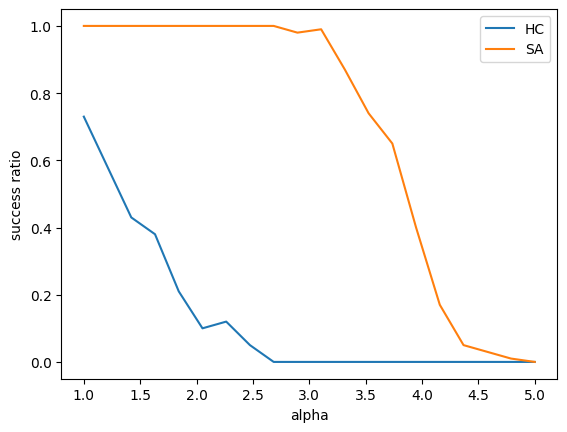

In [ ]:
K = 3
N = 100
n_shots = 100
temp_begin, temp_end = 5e-3, 1e-5
alphas = np.linspace(1, 5, 20)

ratio_hc = []
ratio_sa = []
for alpha in tqdm(alphas):
    M = int(alpha * N)
    cnt_success_hc = cnt_success_sa = 0
    for _ in range(n_shots):
        clauses = create_random_instance(K, N, M)

        energy, _, _ = hill_climbing(N, clauses)
        if energy == 0:
            cnt_success_hc += 1

        energy, _, _ = simulated_annealing(N, clauses, temp_begin, temp_end)
        if energy == 0:
            cnt_success_sa += 1

    ratio_hc.append(cnt_success_hc / n_shots)
    ratio_sa.append(cnt_success_sa / n_shots)

plt.plot(alphas, ratio_hc, label="HC")
plt.plot(alphas, ratio_sa, label="SA")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("success ratio")

SA が HC よりも高い確率で解を見つけられていることがわかります． HCは $\alpha \approx 1.5$ 程度で成功確率が半分程度になっているのに対し，SAでは $\alpha\approx 4$ 程度まで半分以上の成功確率を維持しています．

### 5.3. Warning Inspired Decimation

HC, SA のような局所探索アルゴリズムとは異なるアプローチのアルゴリズムを紹介します．

統計物理学で発達した手法に， message passing という枠組みがあります．これは，因子グラフ上でノード間が「メッセージ」と呼ばれる情報をやり取りすることで，各変数がとる値を計算することができる手法です．

まず，ここでは $K$-SATに対するシンプルな message passing アルゴリズムである， warning propagation (WP) を紹介します．WP では，メッセージは $\{0,1\}$ の2値を取り，以下のような意味を持ちます．
- $u_{a \to i}$: 変数 $i$ が節 $a$ を満たす値を取らなければいけないかどうか
- $h_{j \to a}$: 節 $a$を無視したときに変数 $j$ がどちらの値を取る傾向があるか

これらのメッセージは以下の方程式を満たします．

$$
h_{j\to a} = \sum_{b \in V(j) - a} -J_j^b u_{b \to j} \\
u_{a\to i}=\prod_{j\in V(a) - i} \theta\left( J_j^a h_{j\to a} \right)
$$

ここで， 各変数や関数は以下のように定義されます．
- $V(x)$: 因子グラフでノード$x$と隣接しているノードの集合
- $J_i^a$: 節 $a$ で変数 $i$ が肯定なら $-1$, 否定なら $1$
- $\theta(x)$: ステップ関数 ($x \gt 0$ で $1$ ， $x \leq 0$ で $0$ を取る)

上の方程式を交互に解くことで，各メッセージの値を計算します．

WPは，因子グラフが木のときに厳密な解に収束します．閉路を含む一般のグラフでは収束の保証はなく，収束したとしても厳密解ではないことが多いですが，WPは多くの場合に厳密解の良い近似を与えます．

In [ ]:
"""
Warning Propagation
返り値:
- u: 計算されたメッセージ
- c: 各変数に矛盾があるか (0なら矛盾なし, 1なら矛盾あり)
"""


def warning_propagation(N, clauses, n_iter=100):
    M = len(clauses)
    factor_to_var, var_to_factor, J = build_factor_graph(N, clauses)

    # メッセージをランダムに初期化
    u = [{i: random.randint(0, 1) for i in factor_to_var[a]} for a in range(M)]
    h = [0] * N

    factors = list(range(M))

    for t in range(n_iter):
        converged = True

        random.shuffle(factors)

        for a in factors:
            # j から a
            for j in factor_to_var[a]:
                res = 0
                for b in var_to_factor[j]:
                    if a != b:
                        res += -J[b][j] * u[b][j]
                h[j] = res

            # a から i
            for i in factor_to_var[a]:
                res = 1
                for j in factor_to_var[a]:
                    if i != j:
                        res *= int(J[a][j] * h[j] > 0)
                if u[a][i] != res:
                    converged = False
                u[a][i] = res

        # 収束したら終了
        if converged:
            print(f"converged in {t+1} iterations")
            break
    else:
        print(f"did not converge in {n_iter} iterations")

    # 矛盾
    c = [0] * N
    for i in range(N):
        pos = 0
        neg = 0
        for a in var_to_factor[i]:
            if J[a][i] == -1:
                pos += u[a][i]
            else:
                neg += u[a][i]
        c[i] = int(pos and neg)

    return u, c

以下の例 (文献 [1] の 図3) で正しい解が出るか試します．丸い頂点は変数ノード，四角い頂点は因子ノードを表します．実線は肯定リテラル，点線は否定リテラルを表します．赤い数字は，WPで得られる値を表します．

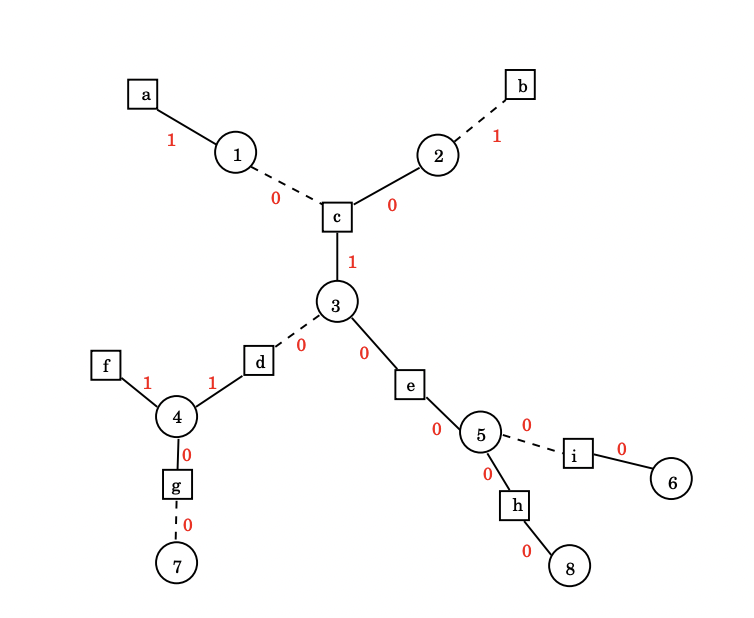

In [ ]:
N = 8
M = 9
clauses = [(0,), (~1,), (~0, 1, 2), (~2, 3), (2, 4), (3,), (3, ~6), (4, 7), (~4, 5)]

In [ ]:
u, c = warning_propagation(N, clauses)

converged in 3 iterations


In [ ]:
u

[{0: 1},
 {1: 1},
 {0: 0, 1: 0, 2: 1},
 {2: 0, 3: 1},
 {2: 0, 4: 0},
 {3: 1},
 {3: 0, 6: 0},
 {4: 0, 7: 0},
 {4: 0, 5: 0}]

In [ ]:
c

[0, 0, 0, 0, 0, 0, 0, 0]

正しい値が得られました．

WP を用いることで．各変数がとるべき値に関する情報が得られました．この情報を用いて実際にSATを解くアルゴリズムを warning inspired decimation と呼びます．

WIDは以下のようなアルゴリズムです．
1. WP を実行する．
2. WP で得られたメッセージを元に，いくつかの変数を決定する
    - 矛盾が見つかる → UNSAT と報告して終了する．
    - 0ではないメッセージがある → そのメッセージを受け取っている変数を，メッセージに対応する値に決定
    - メッセージが全て0 → ランダムに1つ変数を選んでランダムな値に決定
3. すべての変数が決定されたら終了．そうでなければ，決定した変数を因子グラフから取り除き，1に戻る

In [ ]:
"""
updated_vars の変数の値が確定された時に因子グラフを更新する
節の変数が残り一つになったら，その変数を確定させる (unit clause propagation)
矛盾が見つかったら False を返す．矛盾がなければ True を返す．
"""


def reduce_factor_graph(
    factor_to_var,
    var_to_factor,
    J,
    remaining_vars,
    remaining_factors,
    updated_vars,
    value,
):
    satisfied_clauses = set()
    while updated_vars:
        i = updated_vars.pop()

        # 変数 i を取り除く
        remaining_vars.remove(i)
        for a in var_to_factor[i]:
            if 2 * value[i] - 1 == -J[a][i]:
                # 変数 i が節 a を充足する
                satisfied_clauses.add(a)
            else:
                # 節 a から変数 i を取り除く
                factor_to_var[a].remove(i)
                if not factor_to_var[a]:
                    # 矛盾
                    return False
                if len(factor_to_var[a]) == 1:
                    # 変数が一つしかないので値が確定
                    j = factor_to_var[a][0]
                    x = 1 if J[a][j] == -1 else 0
                    if value[j] == -1:
                        value[j] = x
                        updated_vars.append(j)
                    elif value[j] != x:
                        # 矛盾 → UNSAT
                        return False
                    satisfied_clauses.add(a)
    for a in satisfied_clauses:
        # 因子 a を取り除く
        remaining_factors.remove(a)
        for i in factor_to_var[a]:
            var_to_factor[i].remove(a)
        factor_to_var[a] = []
    return True


"""
Warning Inspired Decimation によるソルバ
解が見つかったら変数の割り当て，見つからなかったら None を返す
"""


def warning_inspired_decimation(N, clauses, n_iter=100, verbose=False):
    M = len(clauses)
    factor_to_var, var_to_factor, J = build_factor_graph(N, clauses)

    value = [-1] * N

    remaining_vars = set(range(N))  # まだ確定していない変数
    remaining_factors = set(range(M))  # まだ確定していない節

    # メッセージをランダムに初期化
    u = [{i: random.randint(0, 1) for i in factor_to_var[a]} for a in range(M)]
    h = [0] * N

    while remaining_vars:
        factors = list(remaining_factors)

        # WP 実行
        for t in range(n_iter):
            converged = True

            random.shuffle(factors)

            for a in factors:
                # j から a
                for j in factor_to_var[a]:
                    res = 0
                    for b in var_to_factor[j]:
                        if a != b:
                            res += -J[b][j] * u[b][j]
                    h[j] = res

                # a から i
                for i in factor_to_var[a]:
                    res = 1
                    for j in factor_to_var[a]:
                        if i != j:
                            res *= int(J[a][j] * h[j] > 0)
                    if u[a][i] != res:
                        converged = False
                    u[a][i] = res

            # 収束したら終了
            if converged:
                if verbose:
                    print(f"converged in {t+1} iterations")
                break
        else:
            # 収束しない
            if verbose:
                print(f"did not converge in {n_iter} iterations")

        # 矛盾を確認
        updated_vars = []
        for i in remaining_vars:
            pos = neg = 0
            for a in var_to_factor[i]:
                if J[a][i] == -1:
                    pos += u[a][i]
                else:
                    neg += u[a][i]
            if pos and neg:
                # 矛盾が見つかる → UNSAT
                if verbose:
                    print("a contradiction found")
                return None
            if pos == neg == 0:
                continue
            # 0でない local field → 値を確定
            if pos:
                value[i] = 1
            else:
                value[i] = 0
            updated_vars.append(i)

        if not updated_vars:
            # local field がすべて0 → 変数をランダムに選んで確定
            i = random.choice(list(remaining_vars))
            value[i] = random.randint(0, 1)
            updated_vars.append(i)

        success = reduce_factor_graph(
            factor_to_var,
            var_to_factor,
            J,
            remaining_vars,
            remaining_factors,
            updated_vars,
            value,
        )
        if not success:
            return None

    return value

再び文献 [1] 図3の例で試します．

In [ ]:
N = 8
M = 9
clauses = [(0,), (~1,), (~0, 1, 2), (~2, 3), (2, 4), (3,), (3, ~6), (4, 7), (~4, 5)]

In [ ]:
value = warning_inspired_decimation(N, clauses, verbose=True)
if value:
    print("SAT")
    print(value)
else:
    print("UNSAT")

converged in 3 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
SAT
[1, 0, 1, 1, 1, 1, 0, 1]


確かに解が見つけられました．

次に，3-SAT のランダムインスタンスに対して動作確認をします．

In [ ]:
K = 3
alpha = 3
N = 100
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

In [ ]:
value = warning_inspired_decimation(N, clauses, verbose=True)
print("SAT" if value else "UNSAT")

converged in 7 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
UNSAT


最適解は見つかりませんでしたが，正しく動作していそうです．

$K=3,N=100$ で，様々な $\alpha$ に対して $50$ 個のランダムインスタンスを作成し， WID で解を見つけられる割合をそれぞれ計算します．また，性能を比較するためにHC, SAも実行します．

100%|██████████| 20/20 [02:32<00:00,  7.63s/it]


Text(0, 0.5, 'success ratio')

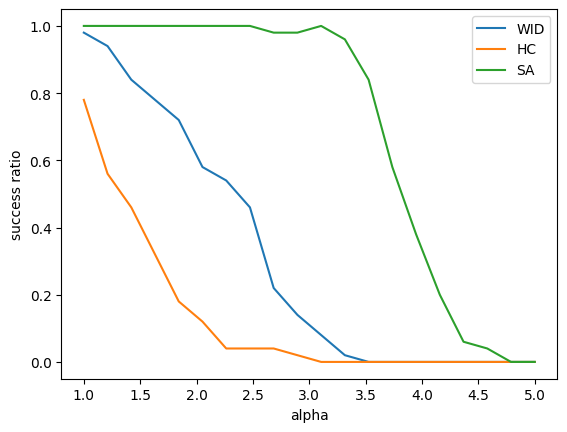

In [ ]:
K = 3
N = 100
n_shots = 50
temp_begin, temp_end = 5e-3, 1e-5
alphas = np.linspace(1, 5, 20)

ratio_wid = []
ratio_hc = []
ratio_sa = []
for alpha in tqdm(alphas):
    M = int(alpha * N)
    cnt_success_wid = cnt_success_hc = cnt_success_sa = 0
    for _ in range(n_shots):
        clauses = create_random_instance(K, N, M)

        value = warning_inspired_decimation(N, clauses)
        if value:
            cnt_success_wid += 1

        energy, _, _ = hill_climbing(N, clauses, n_iter=10**4)
        if energy == 0:
            cnt_success_hc += 1

        energy, _, _ = simulated_annealing(
            N, clauses, temp_begin, temp_end, n_iter=10**4
        )
        if energy == 0:
            cnt_success_sa += 1

    ratio_wid.append(cnt_success_wid / n_shots)
    ratio_hc.append(cnt_success_hc / n_shots)
    ratio_sa.append(cnt_success_sa / n_shots)

plt.plot(alphas, ratio_wid, label="WID")
plt.plot(alphas, ratio_hc, label="HC")
plt.plot(alphas, ratio_sa, label="SA")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("success ratio")

WIDは，HCよりは高性能ですが，SAには劣るという結果が得られました．

## 5.4. Survey Inspired Decimation

SAの節でも説明した通り，$K$-SAT のエネルギーは多くの極小値を持つ複雑な構造を持っています．

似た事例として，統計物理学においても，スピングラスという非常に複雑なエネルギー構造を持つ系が知られています．そこで，スピングラスの解析で発達した cavity 法と呼ばれる手法を応用することで， WP よりもさらに詳細な情報を得ることのできるサーベイ伝搬法 (survey propagation, SP) という手法が生まれました．

$K$-SATの解空間は，hard-SAT領域では複数のクラスタに分裂します．2つの解が，充足性を保ちながら変数の反転を繰り返して互いに到達できるとき，それらの解は同じクラスタに属するといいます．大雑把に言えば，同じクラスタに属する解は互いに似ていると言えます．

そして，それぞれのクラスタの中では，WPによって計算される値が異なります．そこで，「WPメッセージが特定の値を取るクラスタはどれくらいあるか」という値 "survey" を考慮することで，解空間のより詳細な情報を得られることが期待できます．

SP では，メッセージは $[0,1]$ の実数値を取ります．
- $\eta_{a \to i}$ (survey): WPメッセージ $u_{a\to i}$ が $1$ になるクラスタの割合

以下でメッセージが満たす方程式を示します．導出については文献 [1] を参照してください．

$$
\eta_{a\to i}=\prod_{j\in V(a)-i} \left(\frac{\Pi^u_{j\to a}}{\Pi^u_{j\to a}+\Pi^s_{j\to a}+\Pi^0_{j\to a}}\right)
$$

各変数は以下のように定義します．
$$
\Pi^u_{j\to a}=\left(1 - \prod_{b\in V_a^u(j)} (1-\eta_{b\to j}) \right)\prod_{b\in V_a^s(i)}(1-\eta_{b\to j}) \\
\Pi^s_{j\to a}=\left(1 - \prod_{b\in V_a^s(j)} (1-\eta_{b\to j}) \right)\prod_{b\in V_a^u(i)}(1-\eta_{b\to j}) \\
\Pi^0_{j\to a}=\prod_{b\in V(j)-a}(1-\eta_{b\to j})
$$

ここで， $V_a^s(j)$ は，$J_j^a=J_j^b$ を満たす節 $b$ の集合 ($a$ を除く)，$V_a^u(j)$ は， $J_j^a\neq J_j^b$ を満たす節 $b$ の集合です．

上の方程式を用いて $\eta$ と $\Pi^u, \Pi^s, \Pi^0$ を交互に解くことで，各メッセージの値を計算します．

survey の値から，各変数がとる値の分布が計算できます．変数 $i$ がtrue/falseに固定されているクラスタの割合をそれぞれ $W_i^{(+)},W_i^{(-)}$ とすると，これらは次のようにして計算できます．
$$
W_i^{(+)}=\frac{\Pi_i^+}{\Pi_i^++\Pi_i^-+\Pi_i^0} \\
W_i^{(-)}=\frac{\Pi_i^-}{\Pi_i^++\Pi_i^-+\Pi_i^0}
$$
ここで，

$$
\Pi_i^+=\left(1 - \prod_{a\in V_+(i)} (1-\eta_{a\to i}) \right)\prod_{a\in V_-(i)}(1-\eta_{a\to i}) \\
\Pi_i^-=\left(1 - \prod_{a\in V_-(i)} (1-\eta_{a\to i}) \right)\prod_{a\in V_+(i)}(1-\eta_{a\to i}) \\
\Pi_i^0=\prod_{a\in V(i)}(1-\eta_{a\to i}) \\
$$

ここで， $V(i),V_+(i),V_-(i)$はそれぞれ，変数$i$が現れる節の集合，変数$i$が肯定リテラルとして現れる節の集合，変数$i$が否定リテラルとして現れる節の集合です．


easy-SAT 領域では，解空間は複数のクラスタに分裂せず，survey はすべて $0$ に収束します．hard-SAT 領域では，survey が非ゼロの値に収束するようになり，解空間の構造について非自明な情報が得られるので，surveyの値を用いて変数を決定することができます．

survey をもとに変数の値を決定する survey inspired decimation アルゴリズムは以下のようなアルゴリズムです．

1. SP を実行する．
2. SP で得られたsurveyを元に，変数を決定する
    - メッセージがすべて $0$ → 3に進む
    - メッセージが非ゼロ → $W^{(+)},W^{(-)}$の差が最も大きい変数を選び，対応する値に決定．1に戻る
3. まだ決定されていない変数が残っている場合は，適当な局所探索アルゴリズムを用いて残りの問題を解く

本実装では，ステップ3でSAを用います．


In [ ]:
"""
Survey Inspired Decimation によるソルバ
survey がすべて 0 になった時点での変数の割り当てを返す
"""


def survey_inspired_decimation(N, clauses, n_iter=500, eps=1e-2, verbose=False):
    M = len(clauses)
    factor_to_var, var_to_factor, J = build_factor_graph(N, clauses)

    value = [-1] * N

    remaining_vars = set(range(N))  # まだ確定していない変数
    remaining_factors = set(range(M))  # まだ確定していない節

    # メッセージをランダムに初期化
    eta = [{i: random.random() for i in factor_to_var[a]} for a in range(M)]
    gamma = [0] * N

    while remaining_vars:
        factors = list(remaining_factors)

        # SP 実行
        for t in range(n_iter):
            converged = True

            random.shuffle(factors)

            for a in factors:
                # j から a
                for j in factor_to_var[a]:
                    Pu = Ps = P0 = 1
                    for b in var_to_factor[j]:
                        if a != b:
                            if J[a][j] == J[b][j]:
                                Pu *= 1 - eta[b][j]
                            else:
                                Ps *= 1 - eta[b][j]
                            P0 *= 1 - eta[b][j]
                    Pu, Ps = (1 - Ps) * Pu, (1 - Pu) * Ps
                    gamma[j] = Pu / max(Pu + Ps + P0, 1e-18)

                # a から i
                for i in factor_to_var[a]:
                    res = 1
                    for j in factor_to_var[a]:
                        if i != j:
                            res *= gamma[j]
                    if abs(eta[a][i] - res) > eps:
                        converged = False
                    eta[a][i] = res

            # 収束したら終了
            if converged:
                if verbose:
                    print(f"converged in {t+1} iterations")
                break
        else:
            # 収束しない → 諦める
            if verbose:
                print(f"did not converge in {n_iter} iterations")
            return value

        # 非ゼロの survey が存在するか調べる
        trivial = True
        for a in remaining_factors:
            for i in factor_to_var[a]:
                if eta[a][i] > eps:
                    trivial = False
                    break
            if not trivial:
                break

        if trivial:
            return value

        # バイアスを計算
        best_var = (-1, -1, -1)  # (|Wpos - Wneg|, val, i)
        for i in remaining_vars:
            Ppos = Pneg = P0 = 1
            for a in var_to_factor[i]:
                if J[a][i] == 1:
                    Ppos *= 1 - eta[a][i]
                else:
                    Pneg *= 1 - eta[a][i]
                P0 *= 1 - eta[a][i]
            Ppos, Pneg = (1 - Pneg) * Ppos, (1 - Ppos) * Pneg
            Wpos = Ppos / max(Ppos + Pneg + P0, 1e-18)
            Wneg = Pneg / max(Ppos + Pneg + P0, 1e-18)

            diff = abs(Wpos - Wneg)
            if diff > best_var[0]:
                best_var = (diff, 1 if Wpos > Wneg else 0, i)

        # バイアスの偏りが最も大きい変数の値を確定
        _, x, i = best_var
        value[i] = x

        # 因子グラフを更新する
        success = reduce_factor_graph(
            factor_to_var,
            var_to_factor,
            J,
            remaining_vars,
            remaining_factors,
            [i],
            value,
        )
        if not success:
            return None

    return value

再び，文献 [1] の例に対して実行します．

In [ ]:
N = 8
M = 9
clauses = [(0,), (~1,), (~0, 1, 2), (~2, 3), (2, 4), (3,), (3, ~6), (4, 7), (~4, 5)]

In [ ]:
value = survey_inspired_decimation(N, clauses, verbose=True)
print(value)

converged in 3 iterations
converged in 1 iterations
converged in 1 iterations
[1, 0, 1, 1, -1, -1, -1, -1]


確かに，固定値を取る変数については SID で値が決定されています．

次に，3-SATのランダムインスタンスに対して動作確認をします．

In [ ]:
K = 3
alpha = 4
N = 100
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

In [ ]:
value = survey_inspired_decimation(N, clauses, verbose=True)
print(value)

converged in 42 iterations
converged in 12 iterations
converged in 13 iterations
converged in 3 iterations
converged in 8 iterations
converged in 6 iterations
converged in 5 iterations
converged in 3 iterations
converged in 2 iterations
converged in 4 iterations
converged in 11 iterations
converged in 9 iterations
converged in 41 iterations
converged in 14 iterations
converged in 15 iterations
converged in 102 iterations
converged in 239 iterations
converged in 13 iterations
converged in 14 iterations
converged in 5 iterations
converged in 11 iterations
did not converge in 500 iterations
[1, -1, 0, -1, -1, 0, 0, -1, -1, 0, -1, 1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, 1, 0, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1]


SID で survey がすべて 0 になったら，残りを SA で解くアルゴリズムを実装します．

In [ ]:
"""
SID + SA によるソルバ
解が見つかったら変数の割り当て，見つからなかったら None を返す
"""


def sid_sa(
    N,
    clauses,
    temp_begin,
    temp_end,
    n_iter_sp=500,
    n_iter_sa=10**5,
    eps=1e-2,
    verbose=False,
):
    # SIDの実行
    value = survey_inspired_decimation(N, clauses, n_iter_sp, eps, verbose)
    if verbose:
        print("SID finished")
    if not value:
        return None, [], 0

    # 確定していない変数に index を振り直す
    new_var = [-1] * N
    new_N = 0
    for i in range(N):
        if value[i] == -1:
            new_var[i] = new_N
            new_N += 1

    # 節を再構築する
    new_clauses = []
    for clause in clauses:
        satisfied = False
        new_clause = []
        for l in clause:
            if l >= 0:
                i = l
                if value[i] == 1:
                    satisfied = True
                    break
                new_clause.append(new_var[i])
            else:
                i = ~l
                if value[i] == 0:
                    satisfied = True
                    break
                new_clause.append(~new_var[i])
        if not satisfied:
            new_clauses.append(new_clause)
    new_M = len(new_clauses)

    if verbose:
        print(f"original size: N = {N}, M = {M}, alpha = {M / N}")
        print(f"reduced size:  N = {new_N}, M = {new_M}, alpha = {new_M / new_N}")

    energy, value, history = simulated_annealing(
        new_N, new_clauses, temp_begin, temp_end, n_iter=n_iter_sa
    )
    if energy == 0:
        return value, history, N - new_N
    else:
        return None, history, N - new_N

3-SAT のランダムインスタンスに対して動作確認をします．

In [ ]:
K = 3
alpha = 4
N = 100
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

converged in 27 iterations
converged in 2 iterations
converged in 2 iterations
converged in 7 iterations
converged in 3 iterations
converged in 4 iterations
converged in 3 iterations
converged in 6 iterations
converged in 3 iterations
converged in 3 iterations
converged in 8 iterations
converged in 3 iterations
converged in 13 iterations
converged in 11 iterations
converged in 8 iterations
converged in 4 iterations
converged in 7 iterations
converged in 6 iterations
converged in 1 iterations
converged in 8 iterations
converged in 8 iterations
converged in 8 iterations
converged in 2 iterations
converged in 1 iterations
converged in 6 iterations
converged in 10 iterations
converged in 8 iterations
converged in 9 iterations
converged in 4 iterations
converged in 1 iterations
converged in 5 iterations
converged in 8 iterations
converged in 12 iterations
converged in 4 iterations
converged in 6 iterations
converged in 8 iterations
converged in 15 iterations
converged in 7 iterations
conver

Text(0, 0.5, 'energy')

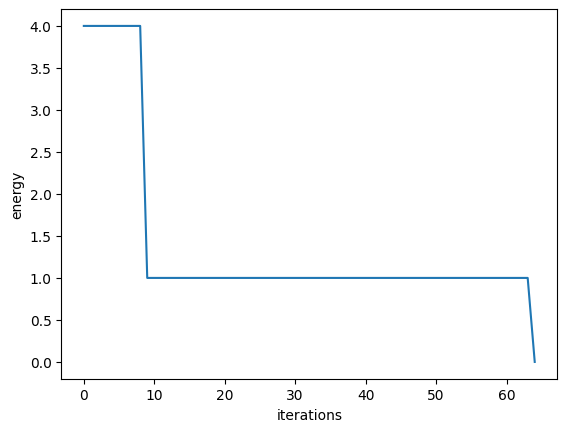

In [ ]:
temp_begin, temp_end = 5e-3, 1e-5

value, history, num_decimated = sid_sa(N, clauses, temp_begin, temp_end, verbose=True)
print("SAT" if value else "UNSAT")
print("energy =", history[-1])
plt.plot(history)
plt.xlabel("iterations")
plt.ylabel("energy")

SIDによって問題サイズが小さくなったため，SAで解きやすくなっていることがわかります．

同じ問題をSAのみで解いてみます．

SAT
energy =  0


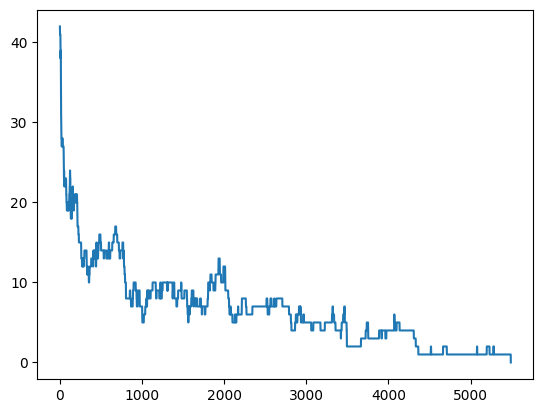

In [ ]:
energy, value, history = simulated_annealing(N, clauses, 5e-3, 1e-5)
print("SAT" if energy == 0 else "UNSAT")
print("energy = ", energy)
plt.plot(history)

この例ではSAでも解を発見することができましたが，SIDを用いたときよりも非常に多くのイテレーションを必要としていることがわかります．

より大きなインスタンスに対して調べてみましょう．

In [ ]:
K = 3
alpha = 4.2
N = 1000
M = int(alpha * N)

clauses = create_random_instance(K, N, M)

converged in 50 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 1 iterations
converged in 2 iterations
converged in 1 iterations
converged in 2 iterations
converged in 1 iterations
converged in 2 iterations
converged in 2 iterations
converged in 1 iterations
converged in 1 iterations
converged in 2 iterations
converged in 2 iterations
converged in 3 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 1 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 2 iterations
converged in 3 iterations
converged in 3 iterations
converged in 2 iterations
converged in 13 iterations
converged 

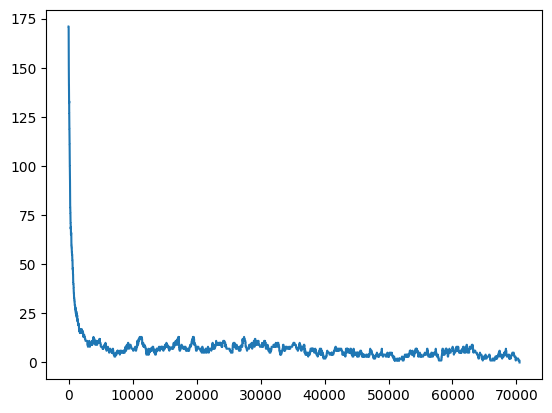

In [ ]:
temp_begin, temp_end = 5e-4, 1e-5

value, history, num_decimated = sid_sa(
    N, clauses, temp_begin, temp_end, n_iter_sa=10**6, verbose=True
)
print("SAT" if value else "UNSAT")
print("energy =", history[-1])
plt.plot(history)

not satisfied
energy =  6


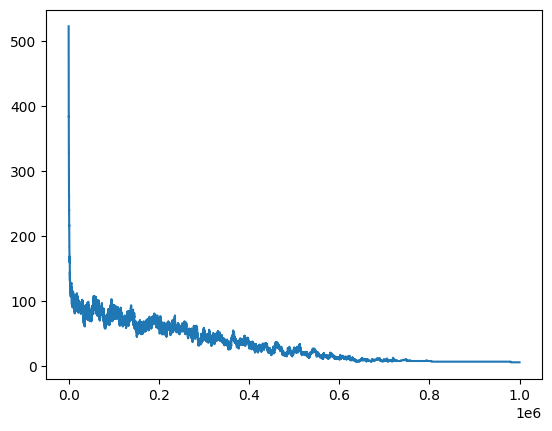

In [ ]:
energy, value, history = simulated_annealing(N, clauses, 5e-4, 1e-5, n_iter=10**6)
print("SAT" if energy == 0 else "UNSAT")
print("energy = ", energy)
plt.plot(history)

$\alpha_c$ に近い大きなインスタンスに対しても，SIDでは解を発見できていることがわかります．

$K=3,N=100$ で，様々な $\alpha$ に対して $100$ 個のランダムインスタンスを作成し， SA, SID で解を見つけられる割合をそれぞれ計算します．

100%|██████████| 20/20 [14:04<00:00, 42.22s/it]


Text(0, 0.5, 'mean number of variables decimated by SID')

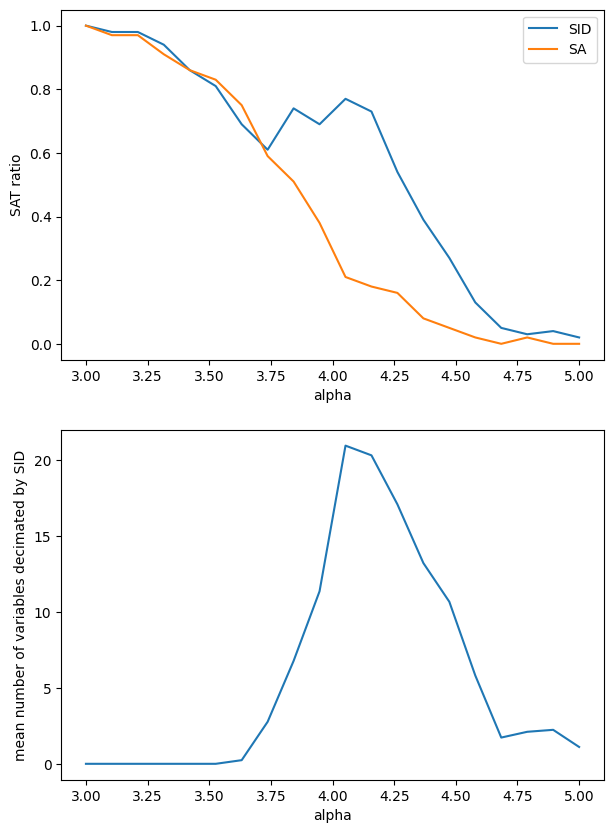

In [ ]:
K = 3
N = 100
n_shots = 100
temp_begin, temp_end = 5e-3, 1e-5
alphas = np.linspace(3, 5, 20)

ratio_sid = []
ratio_sa = []
mean_decimated = []
for alpha in tqdm(alphas):
    M = int(alpha * N)
    cnt_success_sid = cnt_success_sa = total_decimated = 0
    for _ in range(n_shots):
        clauses = create_random_instance(K, N, M)

        value, history, num_decimated = sid_sa(
            N, clauses, temp_begin, temp_end, n_iter_sp=100, n_iter_sa=10**4
        )
        total_decimated += num_decimated
        if value:
            cnt_success_sid += 1

        energy, _, _ = simulated_annealing(
            N, clauses, temp_begin, temp_end, n_iter=10**4
        )
        if energy == 0:
            cnt_success_sa += 1

    ratio_sid.append(cnt_success_sid / n_shots)
    ratio_sa.append(cnt_success_sa / n_shots)
    mean_decimated.append(total_decimated / n_shots)

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].plot(alphas, ratio_sid, label="SID")
ax[0].plot(alphas, ratio_sa, label="SA")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("SAT ratio")
ax[0].legend()
ax[1].plot(alphas, mean_decimated)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("average number of variables decimated by SID")

- $\alpha < 3.7$ 程度では，SIDとSAが同等の性能を示しました．この領域は，surveyがすべて 0 に収束し，SAだけで問題が解けるeasy-SAT領域であると考えられます．
- $3.7 < \alpha < 4.3$ 程度では，SIDがSAを上回る性能を示しました．この領域は，SAだけでは解を発見するのが難しいhard-SAT領域であると考えられ，SPによって得られる情報が解の発見に大きく役立っていることがわかります．
- $\alpha > 4.3$ 程度では，SID，SAともに (確率 0.5 以上で) 解の発見に失敗しています．この領域はUNSAT領域であり，そもそもほとんどのランダムインスタンスがUNSATであると考えられます．

## 6. 結論

本記事では，3-SATのランダムインスタンスに対して，さまざまなアルゴリズムを実行して性能を評価しました．その結果，以下の点を確認することができました．
1. ランダムな3-SATでは確かに $\alpha_c\approx 4.3$ にSAT/UNSAT境界があるらしい
2. SAでは$\alpha_c$に近い $\alpha$ で解を見つけることが難しくなる
3. SIDでは$\alpha_c$に近い $\alpha$ でSAより高い確率で解を見つけることができていた

## 7. あとがき

本記事の実装では，そこまで高速化は行っていません．文献 [1] では，変数を一つずつ決定するのではなく，複数個一気に決定するなどの高速化手法が提案されています．

また，SAT/UNSAT境界やeasy-SAT/hard-SAT境界のより精密な計算については，文献 [2] を参照してください．

また，本記事では，SAがSIDに劣るという結果が得られましたが，個人的には，SAがHCやWIDを大幅に上回る性能を持っていることに驚きました．HCにランダム性を導入するだけで性能が大きく改善するというのは面白いと感じます．SAも平衡統計力学に由来する手法ですから，統計物理学の手法が非常に幅広い可能性を持っていることが伺えます．

Survey propagation の発表以降も，$K$-SATを統計物理学の手法を用いて解くという研究は更なる発展を見せています (例えば文献 [3], [4])．より発展的な手法を実装することにも挑戦してみたいと思います．

## 参考文献

- [1] <div class="csl-entry">Braunstein, A., Mézard, M., &#38; Zecchina, R. (2005). Survey propagation: An algorithm for satisfiability. <i>Random Structures and Algorithms</i>, <i>27</i>(2), 201–226. https://doi.org/10.1002/rsa.20057</div>
- [2] <div class="csl-entry">Mezard, M., &#38; Zecchina, R. (2002). <i>The random K-satisfiability problem: from an analytic solution to an efficient algorithm</i>. https://doi.org/10.1103/PhysRevE.66.056126</div>
- [3] <div class="csl-entry">Marino, R., Parisi, G., &#38; Ricci-Tersenghi, F. (2016). The backtracking survey propagation algorithm for solving random K-SAT problems. <i>Nature Communications</i>, <i>7</i>(1), 12996. https://doi.org/10.1038/ncomms12996</div>
- [4] <div class="csl-entry">Grover, A., Achim, T., &#38; Ermon, S. (2018). <i>Streamlining Variational Inference for Constraint Satisfaction Problems</i>. https://doi.org/10.1088/1742-5468/ab371f</div>

## 記事の担当者

西山颯大